# Mean Variance Optimization
✅Join the Alpha Quant and create profitable bots: https://www.quantreo.com

In [3]:
from scipy.optimize import minimize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Data import
data = pd.read_csv("returns.csv", index_col="Unnamed: 0", parse_dates=True)
data

,Strategy_1,Strategy_2,Strategy_3,Strategy_4,Strategy_5,Strategy_6,Strategy_7,Strategy_8,Strategy_9,Strategy_10
2020-01-01,0.056922,0.035487,-0.002168,0.067602,0.008045,0.005412,-0.002618,0.008953,0.006736,0.005044
2020-01-02,0.016005,-0.009235,0.001437,0.020278,0.043996,-0.002309,0.007790,-0.001830,0.036738,-0.006582
2020-01-03,0.033362,-0.007563,-0.019362,0.008377,-0.075673,0.025308,0.002678,0.000664,-0.054409,-0.039643
2020-01-04,0.071227,-0.018459,0.018403,-0.060222,0.059488,-0.001521,-0.008491,0.002538,-0.037590,0.004485
2020-01-05,0.060027,0.020308,-0.015934,-0.004709,-0.029464,0.002096,-0.024368,-0.003445,-0.064895,-0.010134
...,...,...,...,...,...,...,...,...,...,...
2022-09-22,0.016386,0.000671,0.002819,-0.018476,-0.009396,0.008994,0.001353,0.000693,-0.015385,-0.016885
2022-09-23,-0.001952,-0.042546,0.007687,0.005788,0.138478,0.008730,0.019411,0.003286,-0.033155,-0.001189
2022-09-24,0.006826,0.001608,-0.000345,0.017167,-0.062282,0.000451,-0.012269,-0.001942,0.017123,0.002701
2022-09-25,-0.030428,0.010077,0.002351,0.059599,0.033551,0.004169,-0.010223,-0.002643,0.001982,-0.034974


In [5]:
def dd_function(returns):
    cum_ret = (1+returns).cumprod()-1

    # We compute max of the cumsum on the period (accumulate max) # (1,3,5,3,1) --> (1,3,5,5,5)
    running_max = np.maximum.accumulate(cum_ret + 1)

    # We compute drawdown
    dd = (cum_ret + 1) / running_max - 1

    return dd

<Axes: >

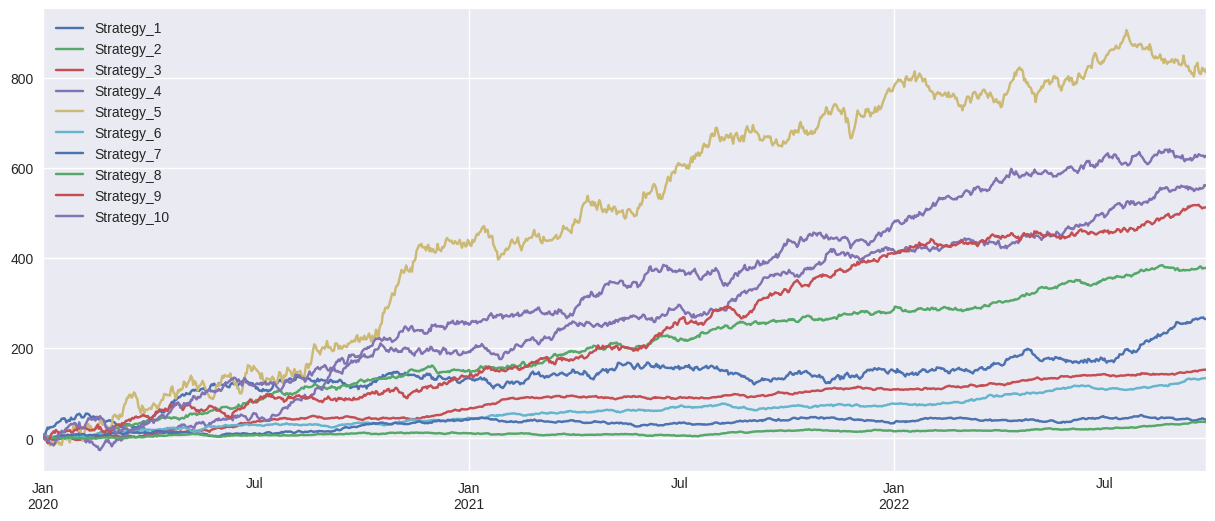

In [6]:
(data.cumsum()*100).plot(figsize=(15,6))

<Axes: >

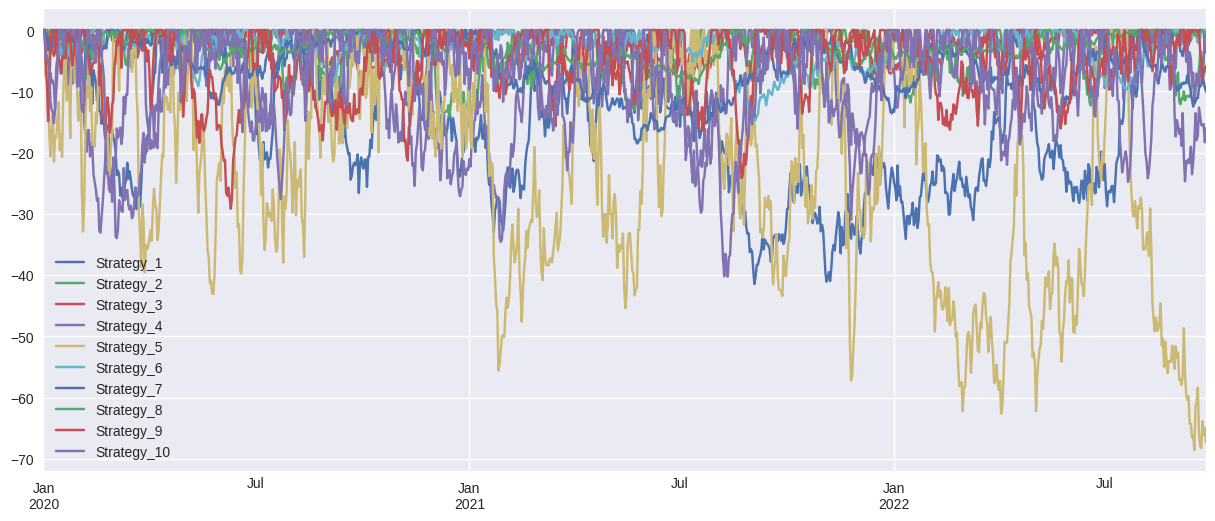

In [7]:
# Create the drawdowns (for each strategy)
dds = []
for col in data.columns:
    dd = dd_function(data[col])
    dds.append(dd)
df_dds = pd.DataFrame(dds).transpose()
(df_dds*100).plot(figsize=(15,6))

In [8]:
def MV_criterion(weights, data):
    """
    -----------------------------------------------------------------------------
    | Output: optimization porfolio criterion                                   |
    -----------------------------------------------------------------------------
    | Inputs: -weight (type ndarray numpy): Wheight for portfolio               |
    |         -data (type ndarray numpy): Returns of stocks                     |
    -----------------------------------------------------------------------------
    """

    # Parameters
    Lambda = 3

    # Compute portfolio returns
    portfolio_return = np.multiply(data, np.transpose(weights))
    portfolio_return = portfolio_return.sum(axis=1)

    # Compute mean and volatility of the portfolio
    mean = np.mean(portfolio_return, axis=0)
    std = np.std(portfolio_return, axis=0)

    # Compute the criterion
    criterion = mean - Lambda * std ** 2

    criterion = -criterion # We always minimize the criterion so be careful

    return criterion

In [9]:
# Define train and test sets
split = int(0.7 * len(data))
train_set = data.iloc[:split, :]
test_set = data.iloc[split:, :]

# Find the number of asset
n = data.shape[1]

# Initialisation weight value
x0 = np.ones(n)

# Optimization constraints problem
cons = ({'type': 'eq', 'fun': lambda x: sum(abs(x)) - 1})

# Set the bounds
Bounds = [(0, 1) for i in range(0, n)]

# Optimization problem solving
res_MV = minimize(MV_criterion, x0, method="SLSQP",
                  args=(train_set), bounds=Bounds,
                  constraints=cons, options={'disp': True})

# Result for computations
X_MV = res_MV.x

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.005099948829967829
            Iterations: 14
            Function evaluations: 154
            Gradient evaluations: 14


In [10]:
(pd.DataFrame(X_MV.round(2), index=[f"Strategy_{i}" for i in range(1,11)], columns=["Weight % "])*100).transpose()

,Strategy_1,Strategy_2,Strategy_3,Strategy_4,Strategy_5,Strategy_6,Strategy_7,Strategy_8,Strategy_9,Strategy_10
Weight %,0.0,15.0,0.0,23.0,16.0,0.0,0.0,0.0,24.0,22.0


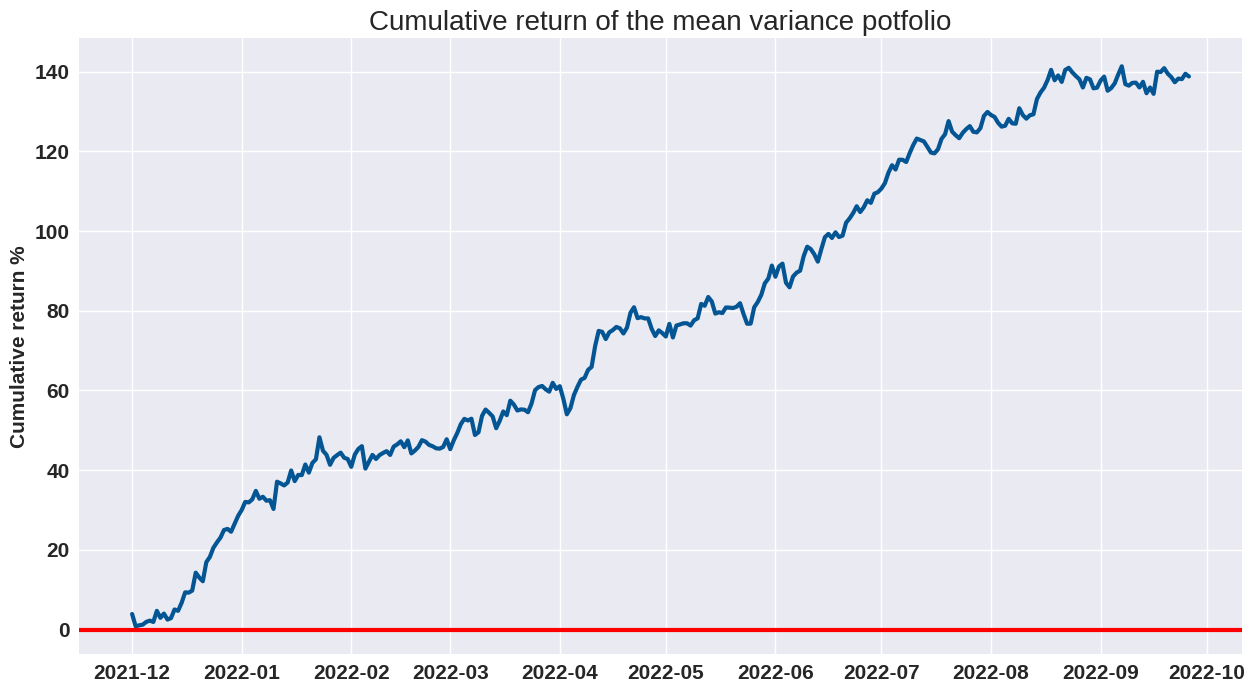

In [11]:
# Compute the cumulative return of the portfolio (CM)
portfolio_return_MV = np.multiply(test_set,np.transpose(X_MV))
portfolio_return_MV = portfolio_return_MV.sum(axis=1)

# Plot the CM
plt.figure(figsize=(15,8))
plt.plot(np.cumsum(portfolio_return_MV)*100, color="#035593", linewidth=3)
plt.ylabel("Cumulative return %", size=15, fontweight="bold")
plt.xticks(size=15,fontweight="bold")
plt.yticks(size=15,fontweight="bold")
plt.title("Cumulative return of the mean variance potfolio", size=20)
plt.axhline(0, color="r",linewidth=3)
plt.show()

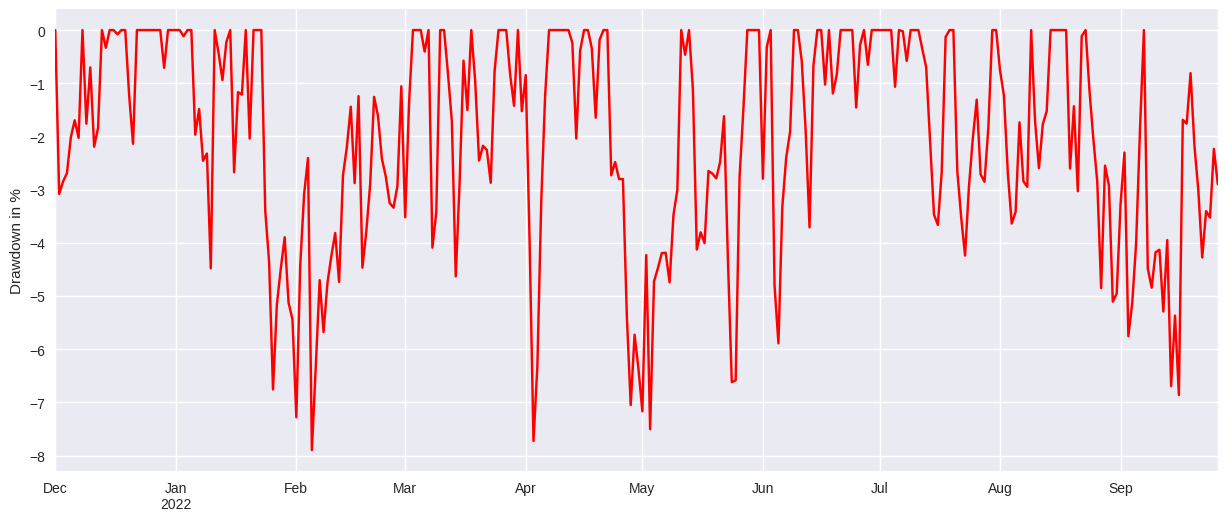

In [16]:
(dd_function(portfolio_return_MV)*100).plot(figsize=(15,6), color="red", ylabel="Drawdown in %")
plt.show()